# Editing distance

## Loading Data

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [2]:
df = pd.read_csv("C:\\Users\\orrbb\\Documents\\BioInformatics\\Msc\\Master\\GNN_Project\\data_all_ab.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\orrbb\\Documents\\BioInformatics\\Msc\\Master\\GNN_Project\\data_all_ab.csv'

In [ ]:
# Calculate the number of non-zero cells for each row
non_zero_counts = (df != 0).sum(axis=1)

# Print the number of non-zero cells for each row
for idx, count in enumerate(non_zero_counts, start=1):
    print(f"Row {idx}: Number of non-zero cells = {count}")


In [ ]:
# Filter rows where the first cell ends with "_H"
filtered_H = df[df.iloc[:, 0].str.endswith("_H")]

In [ ]:
# Filter rows where the first cell ends with "_OC"
filtered_OC = df[df.iloc[:, 0].str.endswith("_OC")]

In [ ]:
# Filter columns where at least one cell in the rows has a non-zero value
filtered_df_H_1 = filtered_H.loc[:, filtered_H.sum() != 0]

# Compute the number of non-zero values in each column
non_zero_counts = filtered_H.astype(bool).sum()

# Define the threshold (n)
threshold = 4

# Filter columns where at least n rows have a value in them
filtered_columns = non_zero_counts[non_zero_counts >= threshold].index

# Create a DataFrame with the filtered columns
filtered_df_H_4 = df[filtered_columns]

In [ ]:
filtered_df_OC_1 = filtered_OC.loc[:, filtered_OC.sum() != 0]
non_zero_counts = filtered_OC.astype(bool).sum()

threshold = 4
filtered_columns = non_zero_counts[non_zero_counts >= threshold].index
filtered_df_OC_4 = df[filtered_columns]

In [ ]:
# first column i "Unnamed:0", should be removed
## healthy
columns_H_1 = filtered_df_H_1.columns[1:].tolist()
columns_H_4 = filtered_df_H_4.columns[1:].tolist()

## sick
columns_OC_1 = filtered_df_OC_1.columns[1:].tolist()
columns_OC_4 = filtered_df_OC_4.columns[1:].tolist()

## Creating the Graphs

In [ ]:
from itertools import combinations
from collections import defaultdict
import pandas as pd
from more_itertools import map_reduce

In [ ]:
# return df with Seq1,2 column. each row is an edge.
def edit_dist_one(tcr_columns):
    # Delimiter used in the input file (e.g., '\t' for tab-separated, ',' for comma-separated)
    default_delimiter = '\t'
    edge_list_header = ['Seq1', 'Seq2']
    print("Starting calculation for edges:\n")
    # Filter out invalid sequences (non-string or length <= 1)
    valid_sequences = filter(lambda x: isinstance(x, str) and len(x) > 1, tcr_columns)
    # Group sequences by their lengths
    sequence_length_table = map_reduce(valid_sequences, len, reducefunc=set)

    # Initialize an empty set to store the edge list
    edge_list = set()
    # Iterate over each length group in the sequence length table
    for sequence_length, sequence_list in sequence_length_table.items():
        # Initialize a dictionary to store sequence groups based on their (length-1) substrings
        substring_groups = defaultdict(set)
        # Iterate over each sequence in the current length group
        for sequence in sequence_list:
            # Generate all (length-1) substrings of the current sequence
            for substring in combinations(sequence, sequence_length - 1):
                # Add the current sequence to the set corresponding to its substring hash
                substring_groups[hash(substring)].add(sequence)

        # If the table contains sequences of length (sequence_length-1), add them to their corresponding substring groups
        if sequence_length - 1 in sequence_length_table:
            for shorter_sequence in sequence_length_table[sequence_length - 1]:
                substring_groups[hash(tuple(shorter_sequence))].add(shorter_sequence)

        # Iterate over each substring group
        for group in filter(lambda g: len(g) > 1, substring_groups.values()):
            # Sort the sequences within the group
            sorted_group = sorted(group)
            # If the last sequence in the sorted group has length (sequence_length-1), it is the "minimum" sequence
            if len(sorted_group[-1]) == sequence_length - 1:
                min_sequence = sorted_group.pop()
                # Add edges between the minimum sequence and all other sequences in the group
                edge_list |= {tuple((min_sequence, s)) for s in sorted_group}
            # Add edges between all pairs of sequences in the group
            edge_list |= set(combinations(sorted_group, 2))
    # Convert the edge list to a list of tuples
    edge_list = list(edge_list)
    edge_df = pd.DataFrame(edge_list, columns=["Seq1", "Seq2"])

    print(f"Edge list - Done.")
    return edge_df


In [ ]:
def draw_graph(edge_list):
    # edge list should be pd df, with 2 columns: Seq1, Seq2
    G = nx.Graph()
    for _, row in edge_list.iterrows():
        source = row['Seq1']
        target = row['Seq2']
        G.add_edge(source, target)
    print("Done adding edges.")
    # Step 5: Adjust plot parameters
    plt.figure(figsize=(12, 8))  # Set the figure size
    nx.draw(G, with_labels=False, node_size=10)  # Adjust node_size

    plt.show()
    return G

In [ ]:
edge_list_H_4 = edit_dist_one(columns_H_4)
H_4_graph = draw_graph(edge_list_H_4)

In [ ]:
edge_list_OC_4 = edit_dist_one(columns_OC_4)
OC_4_graph = draw_graph(edge_list_OC_4)

In [ ]:
print(edge_list_H_4)

In [ ]:
# Adjust plot parameters
plt.figure(figsize=(12, 8))  # Set the figure size

# Draw H_4_graph in blue color
nx.draw(H_4_graph, with_labels=False, node_size=10, node_color='blue')

# Draw OC_4_graph in red color
nx.draw(OC_4_graph, with_labels=False, node_size=10, node_color='red')

# Show the plot
plt.show()

## Exploring the graphs

In [ ]:
print(f"The number of nodes in H4 is: {H_4_graph.number_of_nodes()}. The number of edges is: {H_4_graph.number_of_edges()}")
print(f"The number of nodes in OC is: {OC_4_graph.number_of_nodes()}. The number of edges is: {OC_4_graph.number_of_edges()}")

print(f"average node degree for H4 is: {np.mean([d for _, d in H_4_graph.degree])}")
print(f"average node degree for OC4 is: {np.mean([d for _, d in OC_4_graph.degree])}")

In [ ]:
# Degree centrality of a node is defined as the fraction of nodes it is connected to.
# Betweenness centrality of a node is defined as the fraction of the shortest paths between all pairs of nodes in the graph that pass through that node.
# It measures the influence of a node over the flow of information in the network.

# print(f"Degree centrality is for H4: {nx.degree_centrality(H_4_graph)}, and Betweenness centrality is: {nx.betweenness_centrality(H_4_graph)}")
# print(f"Degree centrality is for OC: {nx.degree_centrality(OC_4_graph)}, and Betweenness centrality is: {nx.betweenness_centrality(OC_4_graph)}")

# Calculate degree centrality for H_4_graph
degree_centrality_H4 = nx.degree_centrality(H_4_graph)
sorted_degree_centrality_H4 = sorted(degree_centrality_H4.items(), key=lambda x: x[1], reverse=True)
top_10_degree_centrality_H4 = sorted_degree_centrality_H4[:10]
# Calculate betweenness centrality for H_4_graph
betweenness_centrality_H4 = nx.betweenness_centrality(H_4_graph)
sorted_betweenness_centrality_H4 = sorted(betweenness_centrality_H4.items(), key=lambda x: x[1], reverse=True)
top_10_betweenness_centrality_H4 = sorted_betweenness_centrality_H4[:10]

# Print top 10 most influential nodes based on degree centrality for H4
print("Top 10 most influential nodes based on degree centrality for H4:")
for node, centrality in top_10_degree_centrality_H4:
    print(f"Node: {node}, Degree centrality: {centrality}")

# Print top 10 most influential nodes based on betweenness centrality for H4
print("\nTop 10 most influential nodes based on betweenness centrality for H4:")
for node, centrality in top_10_betweenness_centrality_H4:
    print(f"Node: {node}, Betweenness centrality: {centrality}")


In [ ]:
# Calculate degree centrality for OC_4_graph
degree_centrality_OC = nx.degree_centrality(OC_4_graph)
sorted_degree_centrality_OC = sorted(degree_centrality_OC.items(), key=lambda x: x[1], reverse=True)
top_10_degree_centrality_OC = sorted_degree_centrality_OC[:10]

# Calculate betweenness centrality for OC_4_graph
betweenness_centrality_OC = nx.betweenness_centrality(OC_4_graph)
sorted_betweenness_centrality_OC = sorted(betweenness_centrality_OC.items(), key=lambda x: x[1], reverse=True)
top_10_betweenness_centrality_OC = sorted_betweenness_centrality_OC[:10]

# Print top 10 most influential nodes based on degree centrality for OC
print("\nTop 10 most influential nodes based on degree centrality for OC:")
for node, centrality in top_10_degree_centrality_OC:
    print(f"Node: {node}, Degree centrality: {centrality}")

# Print top 10 most influential nodes based on betweenness centrality for OC
print("\nTop 10 most influential nodes based on betweenness centrality for OC:")
for node, centrality in top_10_betweenness_centrality_OC:
    print(f"Node: {node}, Betweenness centrality: {centrality}")

In [ ]:
# Determine the number of connected components
print("Number of connected components in H_4:", nx.number_connected_components(H_4_graph))
print("Number of connected components in OC_4:", nx.number_connected_components(OC_4_graph))

In [ ]:
communities_H4 = nx.algorithms.community.greedy_modularity_communities(H_4_graph)
# Calculate the sizes of each community
community_sizes_H4 = [(communities_H4, len(nodes)) for community, nodes in enumerate(communities_H4, start=1)]

# Sort the communities by size in descending order
sorted_community_sizes_H4 = sorted(community_sizes_H4, key=lambda x: x[1], reverse=True)

# Print the sizes of the communities ordered by size
print("Sizes of communities ordered by size:")
for i, (community, size) in enumerate(sorted_community_sizes_H4, start=1):
    print(f"Community {i}: Size {size}")


In [ ]:
communities_OC4 = nx.algorithms.community.greedy_modularity_communities(OC_4_graph)
# Calculate the sizes of each community
community_sizes_OC4 = [(communities_OC4, len(nodes)) for community, nodes in enumerate(communities_OC4, start=1)]

# Sort the communities by size in descending order
sorted_community_sizes_OC4 = sorted(community_sizes_OC4, key=lambda x: x[1], reverse=True)

# Print the sizes of the communities ordered by size
print("Sizes of communities ordered by size:")
for i, (community, size) in enumerate(sorted_community_sizes_OC4, start=1):
    print(f"Community {i}: Size {size}")

## Comparing the graphs

In [ ]:
# TODO: should run more elaborate comparison, to find influence nodes that are not shared.
# 1. Calculate the overlap of nodes between the two graphs
node_overlap = set(H_4_graph.nodes()).intersection(OC_4_graph.nodes())
print("Node overlap between H4 and OC4:", len(node_overlap))

# 2. Calculate the overlap of edges between the two graphs
edge_overlap = set(H_4_graph.edges()).intersection(OC_4_graph.edges())
print("Edge overlap between H4 and OC4:", len(edge_overlap))

In [ ]:

# 1. Node Matching
# Calculate Jaccard similarity coefficient for each pair of common nodes
common_nodes = set(H_4_graph.nodes()).intersection(OC_4_graph.nodes())
jaccard_similarity = {}
for node in common_nodes:
    neighbors_H = set(H_4_graph.neighbors(node))
    neighbors_OC = set(OC_4_graph.neighbors(node))
    jaccard_similarity[node] = len(neighbors_H.intersection(neighbors_OC)) / len(neighbors_H.union(neighbors_OC))

# Sort nodes by Jaccard similarity coefficient in descending order
sorted_nodes = sorted(jaccard_similarity.items(), key=lambda x: x[1], reverse=True)

# Select top matching nodes based on Jaccard similarity coefficient
top_matching_nodes = [node for node, _ in sorted_nodes[:1000]]

# 2. Subgraph Extraction
# Extract subgraphs containing only the top matching nodes
subgraph_H = H_4_graph.subgraph(top_matching_nodes)
subgraph_OC = OC_4_graph.subgraph(top_matching_nodes)

# 3. Graph Alignment (Optional)
# You can perform additional alignment or similarity analysis here if needed.

# 4. Visualization
# Visualize the aligned subgraphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(subgraph_H, with_labels=True, node_color='lightblue', font_size=8)
plt.title('Subgraph from H_4_graph')

plt.subplot(1, 2, 2)
nx.draw(subgraph_OC, with_labels=True, node_color='lightgreen', font_size=8)
plt.title('Subgraph from OC_4_graph')

plt.tight_layout()
plt.show()


In [ ]:
# Get connected components for H_4_graph
connected_components_h4 = list(nx.connected_components(H_4_graph))

# Sort connected components by size
sorted_connected_components_h4 = sorted(connected_components_h4, key=len, reverse=True)
print("H_4 graph:")
# Print the sizes of the 10 largest connected components in H_4_graph
for i, component in enumerate(sorted_connected_components_h4[:10], start=1):
    print(f"Connected Component {i}: Size = {len(component)}")

# Repeat the same process for OC_4_graph
connected_components_oc4 = list(nx.connected_components(OC_4_graph))
sorted_connected_components_oc4 = sorted(connected_components_oc4, key=len, reverse=True)
print("OC_4 graph:")
for i, component in enumerate(sorted_connected_components_oc4[:10], start=1):
    print(f"Connected Component {i}: Size = {len(component)}")


In [ ]:

# Get the 10 largest connected components from H_4_graph and OC_4_graph
largest_connected_h4 = sorted(nx.connected_components(H_4_graph), key=len, reverse=True)[:10]
largest_connected_oc4 = sorted(nx.connected_components(OC_4_graph), key=len, reverse=True)[:10]

# Create graphs for healthy and sick patients
healthy_graph = nx.Graph()
sick_graph = nx.Graph()

# Add nodes and edges from the 10 largest connected components to the respective graphs
for component in largest_connected_h4:
    healthy_graph.add_nodes_from(component)
    healthy_graph.add_edges_from(H_4_graph.subgraph(component).edges())

for component in largest_connected_oc4:
    sick_graph.add_nodes_from(component)
    sick_graph.add_edges_from(OC_4_graph.subgraph(component).edges())

# Draw the graphs
plt.figure(figsize=(12, 8))

# Draw healthy patients in blue color
pos_h4 = nx.spring_layout(healthy_graph)
nx.draw(healthy_graph, pos_h4, node_color='blue', with_labels=False, node_size=10)

# Draw sick patients in red color
pos_oc4 = nx.spring_layout(sick_graph)
nx.draw(sick_graph, pos_oc4, node_color='red', with_labels=False, node_size=10)

plt.show()


In [ ]:
edge_list_H_4.columns = ['source', 'target']
edge_list_H_4.to_csv("H4_edge_list.csv", index=False)

edge_list_OC_4.columns = ['source', 'target']
edge_list_OC_4.to_csv("OC4_edge_list.csv", index=False)

## Spectral Embedding
In spectral embedding, the dimensions or axes you see in the graph are representations derived from the eigenvalues and eigenvectors of the Laplacian matrix of the graph. Here's a breakdown of how this works and what the values represent:

The Laplacian Matrix
Construction: The graph Laplacian is a matrix representation of a graph and is derived from the difference between the degree matrix and the adjacency matrix of the graph. The degree matrix is a diagonal matrix that contains information about the number of connections (or edges) each node (or vertex) has. The adjacency matrix indicates whether pairs of nodes are directly connected.
Role of Laplacian: The Laplacian matrix is critical in studying the properties of the graph, such as connectivity and the flow of information. It's used extensively in spectral graph theory to explore the structure of networks.
Eigenvalues and Eigenvectors
Eigenvalues: These are values derived from the Laplacian matrix that provide information about the overall structure of the graph. Smaller eigenvalues correspond to more fundamental or more connected components of the graph.
Eigenvectors: Each eigenvalue has a corresponding eigenvector, which provides a vector of coefficients describing the influence or participation of each node in that eigenvalue's structural pattern.

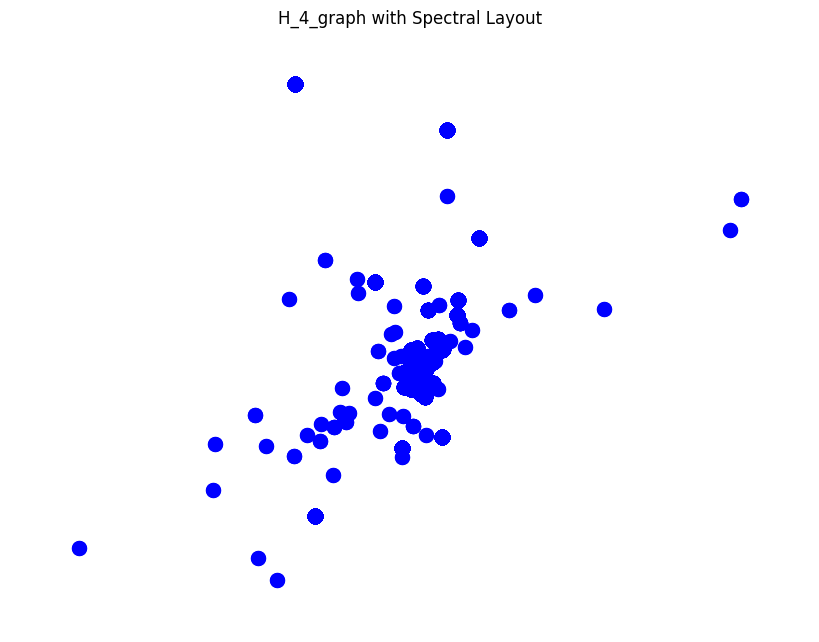

In [129]:
## Spectral embedding
plt.figure(figsize=(8, 6))
nx.draw_spectral(H_4_graph, node_color="blue", node_size=100)
plt.title("H_4_graph with Spectral Layout")
plt.show()

In [130]:
from sklearn.manifold import SpectralEmbedding

In [131]:
def plot_spectral_embedding(embedding, color):
    # Plot the embedded graph
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap=plt.cm.jet)
    plt.title('Spectral Embedding for OC4 Graph')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    plt.show()

C:\Users\orrbb\AppData\Local\Temp\ipykernel_29664\2184416677.py:4: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



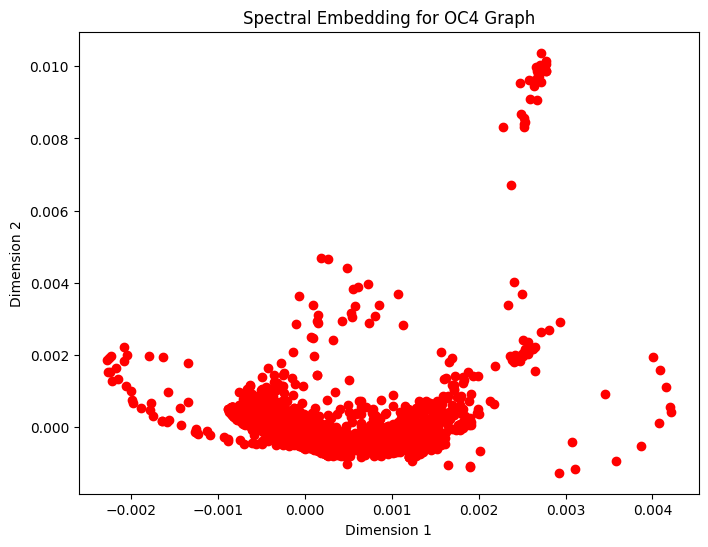

In [132]:
spectral_OC = SpectralEmbedding(n_components=2)
adjacency_matrix_OC = nx.to_numpy_array(OC_4_graph)
embedding_OC = spectral_OC.fit_transform(adjacency_matrix_OC)

plot_spectral_embedding(embedding_OC, 'r')


C:\Users\orrbb\AppData\Local\Temp\ipykernel_29664\2184416677.py:4: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



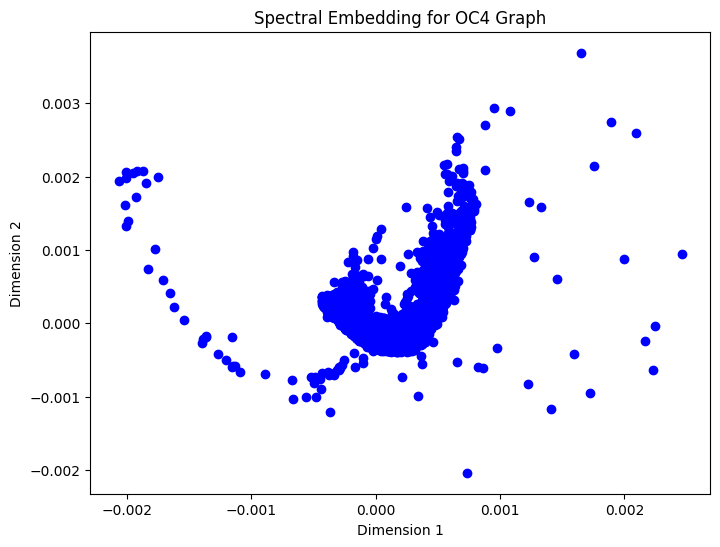

In [133]:
spectral_H = SpectralEmbedding(n_components=2)
adjacency_matrix_H = nx.to_numpy_array(H_4_graph)
embedding_H = spectral_H.fit_transform(adjacency_matrix_H)

plot_spectral_embedding(embedding_H, color='b')

In [134]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_spectral_embedding_3d(embedding, color):
    # Plot the embedded graph in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=color, cmap=plt.cm.jet)
    ax.set_title('Spectral Embedding for OC4 Graph')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')

    plt.show()


C:\Users\orrbb\AppData\Local\Temp\ipykernel_29664\203235079.py:8: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



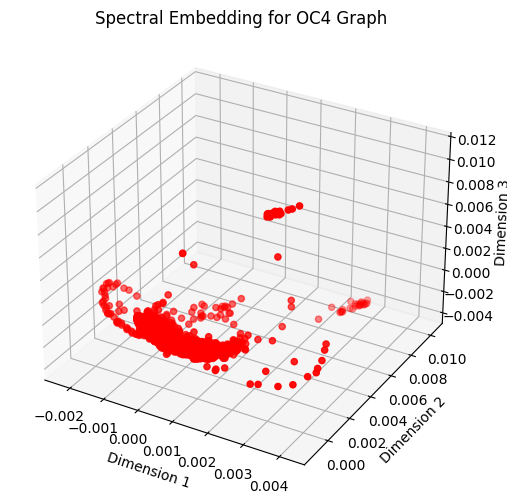

C:\Users\orrbb\AppData\Local\Temp\ipykernel_29664\203235079.py:8: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



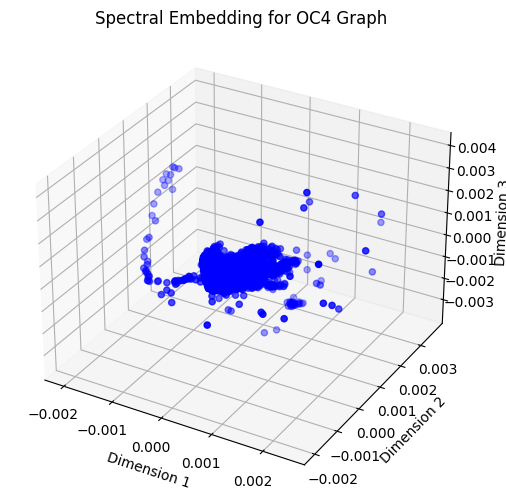

In [135]:
spectral = SpectralEmbedding(n_components=3)
adjacency_matrix = nx.to_numpy_array(OC_4_graph)
embedding = spectral.fit_transform(adjacency_matrix)
plot_spectral_embedding_3d(embedding, color='r')

spectral = SpectralEmbedding(n_components=3)
adjacency_matrix = nx.to_numpy_array(H_4_graph)
embedding = spectral.fit_transform(adjacency_matrix)
plot_spectral_embedding_3d(embedding, color='b')


In [136]:
import plotly.graph_objs as go

def plot_spectral_embedding_3d_move(embedding, color):
    # Create a scatter plot
    trace = go.Scatter3d(
        x=embedding[:, 0],
        y=embedding[:, 1],
        z=embedding[:, 2],
        mode='markers',
        marker=dict(color=color, colorscale='Jet', size=5)
    )

    # Create the layout
    layout = go.Layout(
        title='Spectral Embedding for OC4 Graph',
        scene=dict(
            xaxis=dict(title='Dimension 1'),
            yaxis=dict(title='Dimension 2'),
            zaxis=dict(title='Dimension 3')
        )
    )

    # Create the figure
    fig = go.Figure(data=[trace], layout=layout)

    # Show the plot
    fig.show()


In [137]:
spectral = SpectralEmbedding(n_components=3)
adjacency_matrix = nx.to_numpy_array(OC_4_graph)
embedding = spectral.fit_transform(adjacency_matrix)
plot_spectral_embedding_3d_move(embedding, color='red')

spectral = SpectralEmbedding(n_components=3)
adjacency_matrix = nx.to_numpy_array(H_4_graph)
embedding = spectral.fit_transform(adjacency_matrix)
plot_spectral_embedding_3d_move(embedding, color='blue')

## PCA
Notice that PCA uses the Spectral embedding as a replacement for features (that are not present in the current graph, containing only TCR sequences).

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Perform PCA on the embedding
pca = PCA(n_components=2)  # You can specify the number of components you want
embedding_pca = pca.fit_transform(embedding_OC)

# Plot the PCA-transformed embedding
plot_spectral_embedding(embedding_pca, 'r')

In [ ]:
# Perform PCA on the embedding
pca = PCA(n_components=2)  # You can specify the number of components you want
embedding_pca = pca.fit_transform(embedding_H)

# Plot the PCA-transformed embedding
plot_spectral_embedding(embedding_pca, 'b')

# Chemical distance

## Loading the data

In [ ]:

# Create a DataFrame to store node IDs
node_data = pd.DataFrame(columns=['node_id'])

# Iterate over nodes and add their IDs to the DataFrame
for node in H_4_graph.nodes():
    node_data = node_data.append({'node_id': node}, ignore_index=True)

# Save node IDs to CSV file
node_data.to_csv('./csv_files/H4_nodes.csv', index=False)

# Create a DataFrame to store node IDs
node_data = pd.DataFrame(columns=['node_id'])

# Iterate over nodes and add their IDs to the DataFrame
for node in OC_4_graph.nodes():
    node_data = node_data.append({'node_id': node}, ignore_index=True)

# Save node IDs to CSV file
node_data.to_csv('./csv_files/OC4_nodes.csv', index=False)

In [104]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [111]:
def creat_chem_graph(csv_path):
    # loading files
    with open(csv_path) as json_file:
        couples_by_che = json.load(json_file)
    couples = couples_by_che

    max_neig = 1
    # Create a graph
    G = nx.Graph()
    # Add edges to the graph based on the dictionary
    for node, neighbors in couples.items():
        count = 0
        for neighbor, weight in neighbors:
            if count < max_neig:
                G.add_edge(node, neighbor, weight=weight)
                count += 1
    return G

In [112]:
Oc_4_chem_graph = creat_chem_graph("./output_files/tests/node_id/che_phy_OC.json")


In [114]:
H_4_chem_graph = creat_chem_graph("./output_files/tests/node_id/che_phy_H4.json")

## Exploring the graphs

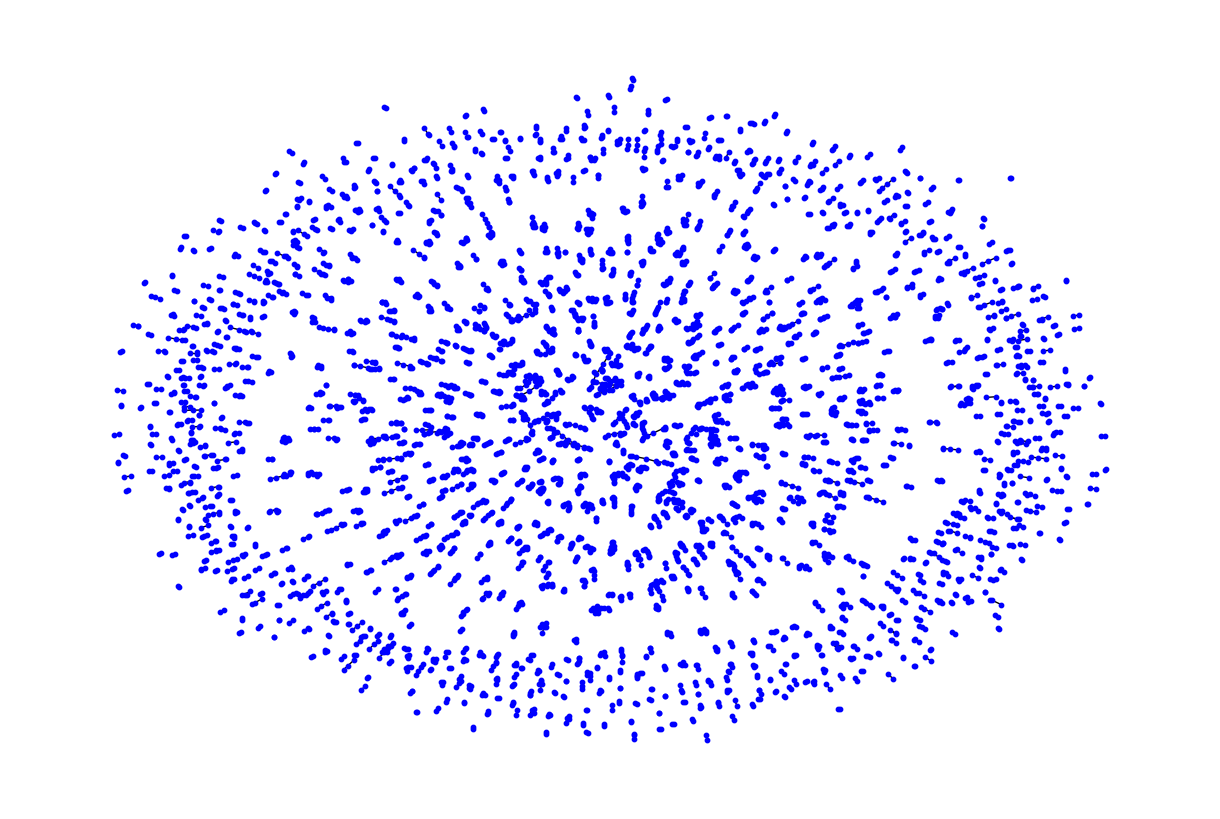

In [113]:
# Adjust plot parameters
plt.figure(figsize=(12, 8))  # Set the figure size

# Draw H_4_graph in blue color
nx.draw(Oc_4_chem_graph, with_labels=False, node_size=10, node_color='blue')

plt.show()

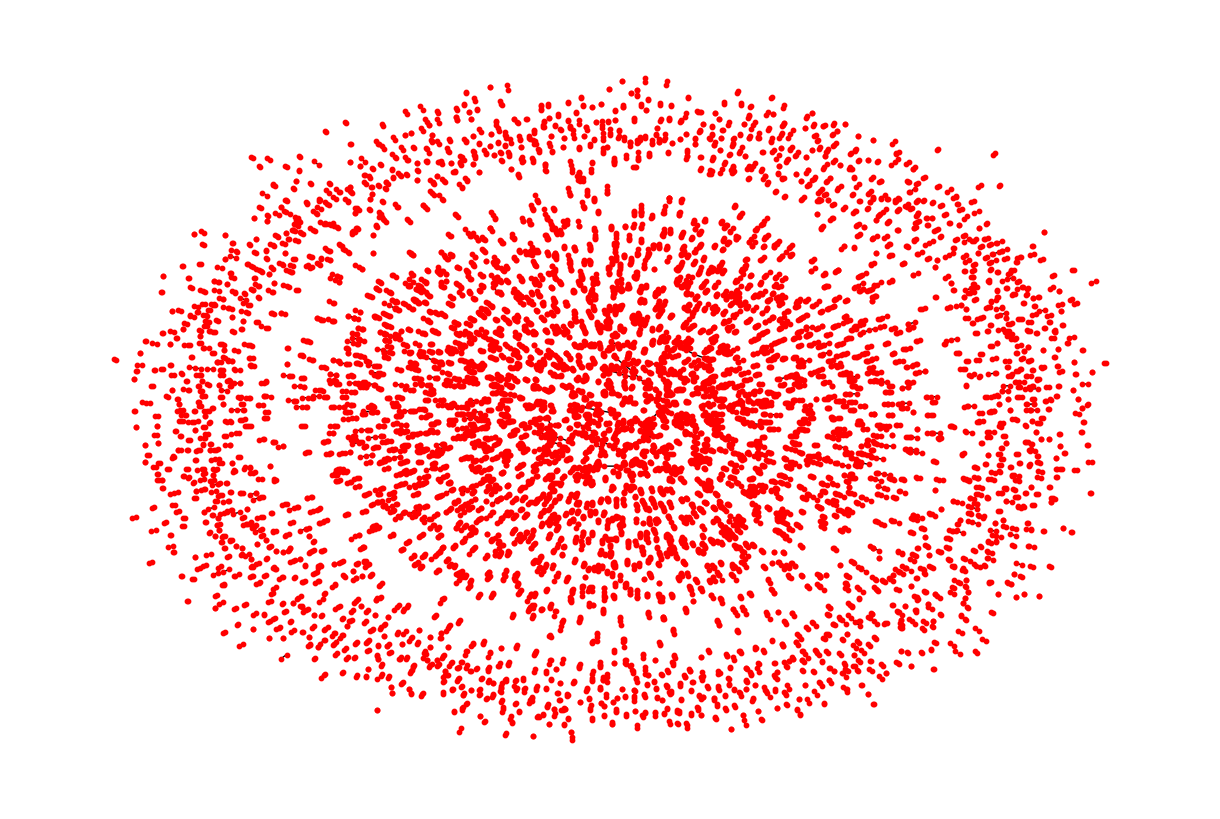

In [115]:
# Adjust plot parameters
plt.figure(figsize=(12, 8))  # Set the figure size

# Draw H_4_graph in blue color
nx.draw(H_4_chem_graph, with_labels=False, node_size=10, node_color='red')

plt.show()

In [ ]:
def basic_graph_stats(G):
    print(f"The number of nodes in graph is: {G.number_of_nodes()}. The number of edges is: {G.number_of_edges()}")
    print(f"average node degree is: {np.mean([d for _, d in G.degree])}")
    print(f"Graph density is:{nx.density(G)}")
    print(f"Average clustering coefficient:{nx.average_clustering(G)}")
        # Check if the graph is connected before calculating diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter: {diameter}")
    else:
        print("Graph is not connected, cannot compute diameter.")


def visualize_graph(G):
    plt.figure(figsize=(10, 8))
    # Spring layout
    plt.subplot(2, 2, 1)
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
    plt.title("Spring Layout")
    # Circular layout
    plt.subplot(2, 2, 2)
    pos = nx.circular_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
    plt.title("Circular Layout")
    # Kamada-Kawai layout
    plt.subplot(2, 2, 3)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
    plt.title("Kamada-Kawai Layout")
    plt.tight_layout()
    plt.show()

def centrality_community_measures(G):
    # Calculate degree centrality for graph
    degree_centrality = nx.degree_centrality(G)
    sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    top_10_degree_centrality = sorted_degree_centrality[:10]
    # Calculate betweenness centrality for graph
    betweenness_centrality = nx.betweenness_centrality(G)
    sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    top_10_betweenness_centrality = sorted_betweenness_centrality[:10]

    # Print top 10 most influential nodes based on degree centrality for H4
    print("Top 10 most influential nodes based on degree centrality:")
    for node, centrality in top_10_degree_centrality:
        print(f"Node: {node}, Degree centrality: {centrality}")

    # Print top 10 most influential nodes based on betweenness centrality for H4
    print("\nTop 10 most influential nodes based on betweenness centrality:")
    for node, centrality in top_10_betweenness_centrality:
        print(f"Node: {node}, Betweenness centrality: {centrality}")

    ## Comunnities
    communities = nx.algorithms.community.greedy_modularity_communities(G)
    # Calculate the sizes of each community
    community_sizes = [(communities, len(nodes)) for community, nodes in enumerate(communities, start=1)]
    total_comm_size = sum(size for _, size in community_sizes)
    print (f"Average community size is: {total_comm_size / len(community_sizes)}")
    if (len(community_sizes) < 50):
        # Sort the communities by size in descending order
        sorted_community_sizes = sorted(community_sizes, key=lambda x: x[1], reverse=True)

        # Print the sizes of the communities ordered by size
        print("Sizes of communities ordered by size:")
        for i, (community, size) in enumerate(sorted_community_sizes, start=1):
            print(f"Community {i}: Size {size}")

    ## Connected components
    # Determine the number of connected components
    print("Number of connected components in graph:", nx.number_connected_components(G))
    # Get the 10 largest connected components from H_4_graph and OC_4_graph
    largest_connected = sorted(nx.connected_components(G), key=len, reverse=True)[:10]
    connected_graph = nx.Graph()
    # Add nodes and edges from the 10 largest connected components to the graph
    for component in largest_connected:
        connected_graph.add_nodes_from(component)
        connected_graph.add_edges_from(G.subgraph(component).edges())

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(connected_graph)
    nx.draw(connected_graph, pos, node_color='red', with_labels=False, node_size=10)

    plt.show()

def path_analysis(G):
    # Shortest paths
    shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

    # Calculate average shortest path length
    total_shortest_paths = sum(sum(length for length in lengths.values()) for lengths in shortest_paths.values())
    num_pairs = sum(len(lengths) for lengths in shortest_paths.values())
    avg_shortest_path_length = total_shortest_paths / num_pairs

    print("Average shortest path length:", avg_shortest_path_length)

    # Path length distribution
    path_lengths = [length for lengths in shortest_paths.values() for length in lengths.values()]

    plt.hist(path_lengths, bins=max(path_lengths)+1, alpha=0.7)
    plt.title("Path Length Distribution")
    plt.xlabel("Path Length")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def assortativity_analysis(G):
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    attribute_assortativity = nx.attribute_assortativity_coefficient(G, 'attribute_name')

    print("Degree Assortativity Coefficient:", degree_assortativity)
    print("Attribute Assortativity Coefficient:", attribute_assortativity)

def subgraph_analysis(G):
    # Identify and analyze subgraphs
    subgraphs = list(nx.connected_component_subgraphs(G))
    num_subgraphs = len(subgraphs)

    print("Number of subgraphs:", num_subgraphs)

    # Visualize largest subgraph
    largest_subgraph = max(subgraphs, key=len)
    plt.figure(figsize=(8, 6))
    nx.draw(largest_subgraph, with_labels=True)
    plt.title("Largest Subgraph Visualization")
    plt.show()

def graph_algorithms(G):
    print("Traversal Order:", list(nx.dfs_preorder_nodes(G)))
    print("Breadth-First Search Tree Edges:", nx.bfs_tree(G, source=list(G.nodes())[0]))
    print("Minimum Spanning Tree Edges:", nx.minimum_spanning_tree(G))
    print("Strongly Connected Components:", list(nx.strongly_connected_components(G)))
    print("Weakly Connected Components:", list(nx.weakly_connected_components(G)))
    print("Articulation Points:", list(nx.articulation_points(G)))
    print("Bridges:", list(nx.bridges(G)))
    print("Cycles:", list(nx.simple_cycles(G)))



In [127]:
def eda_graph(G):
    basic_graph_stats(G)
    visualize_graph(G)
    centrality_community_measures(G)
    path_analysis(G)
    assortativity_analysis(G)
    subgraph_analysis(G)
    graph_algorithms(G)

The number of nodes in graph is: 4683. The number of edges is: 3396
average node degree is: 1.450352338244715
Graph density is:0.0003097719645973334
Average clustering coefficient::0.0
Graph is not connected, cannot compute diameter.


KeyboardInterrupt: 

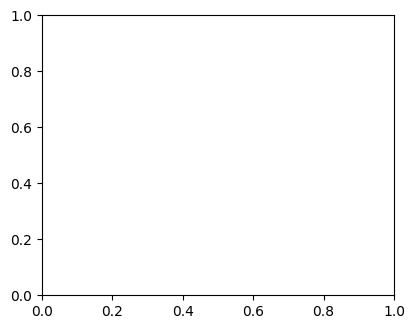

In [128]:
eda_graph(Oc_4_chem_graph)

The number of nodes in graph is: 11017. The number of edges is: 7906
average node degree is: 1.4352364527548334
Top 10 most influential nodes based on degree centrality:
Node: VNTGFQKL, Degree centrality: 0.000635439360929557
Node: AVNTDKLI, Degree centrality: 0.0005446623093681917
Node: VRNNNARL, Degree centrality: 0.0005446623093681917
Node: VRGNQGGK, Degree centrality: 0.00045388525780682646
Node: TKAAGNKL, Degree centrality: 0.00045388525780682646
Node: SANYGGSQ, Degree centrality: 0.00045388525780682646
Node: TSGGSNYK, Degree centrality: 0.00045388525780682646
Node: SPGTGNTG, Degree centrality: 0.00045388525780682646
Node: VGANDYKL, Degree centrality: 0.00045388525780682646
Node: ATNSGYAL, Degree centrality: 0.00045388525780682646

Top 10 most influential nodes based on betweenness centrality:
Node: ASSFSYEQ, Betweenness centrality: 8.406045628015668e-07
Node: ASSISYEQ, Betweenness centrality: 7.746747931700714e-07
Node: ASSTSYEQ, Betweenness centrality: 6.922625811307021e-07
Node

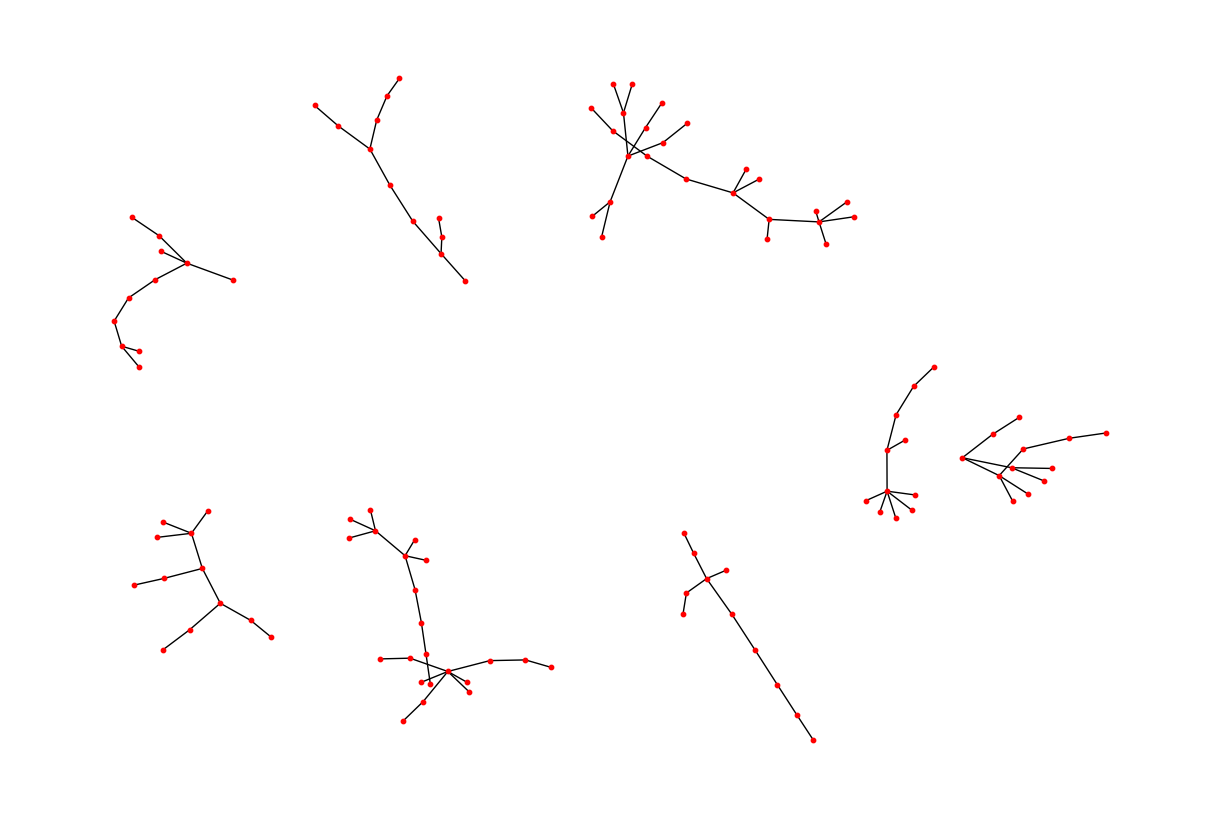

In [122]:
eda_graph(H_4_chem_graph)
